# Epileptic Seizure Recognition

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/epileptic_seizure.gif)

A sudden rush of electric activity in the brain is called a seizure. Epilepsy is a chronic neurological disorder causing involuntory, recurrent seizures.

Seizures can either be generalized (affecting the whole brain) or focussed (affecting one part of the brain).

Deep learning can be used to detect and monitor seizures in patients and IoT provides an ease of integration with the existing health system and patient wearability.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import random
import matplotlib.pyplot as plt

# The dataset

>Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

The CSV file consists of processed EEG recordings of patients at different points of time.

The original dataset has 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. This was then divided and shuffled into 23 chunks, each chunk containing 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. Thus, we have 23 x 500 = 11500 pieces of information, each information contains 178 data points for 1 second.

The last column contains the categorical variable with the following values - 

* 5 - Recording the EEG signal of the brain when the patient had their eyes open

* 4 - Recording the EEG signal when the patient had their eyes closed

* 3 - Recording the EEG activity from the healthy brain area

* 2 - Recordering the EEG from the area where the tumor was located

* 1 - Recording of seizure activity

Here, only label 1 corresponds to seizure activity.

We will be training the model to identify patients with seizure activity against the rest of the classes.

In [2]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Epileptic_Seizure_Recognition.csv')
df

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


As we will be classifying samples into two categories, epileptic (label 1) and non-epileptic (labels 2, 3, 4, 5), we will change the labels in the dataframe.

In [3]:
df['y'] = (df['y'] ==1).astype('int')
df['y']

0        0
1        1
2        0
3        0
4        0
        ..
11495    0
11496    1
11497    0
11498    0
11499    0
Name: y, Length: 11500, dtype: int64

In [4]:
# The spread of labels in the dataframe
df['y'].value_counts()

0    9200
1    2300
Name: y, dtype: int64

This is an unbalanced dataest. 

In [5]:
# Defining a list with class names corresponding to list indices
class_names = ['Non-epileptic', 'Epileptic']

# Preprocessing

## Resampling

In order to balance the dataset, there are two options,

* upsampling - resample the values to make their count equal to the class label with the higher count (here, 9200).
* downsampling - pick n samples from each class label where n = number of samples in class with least count (here, 2300)

Here, we will be upsampling.

In [6]:
# separating into 2 dataframes, one for each class 

df1 = df[df['y'] == 1]
df0 = df[df['y'] == 0]

In [7]:
print("Number of samples in:")
print("Class label 0 - ", len(df0))
print("Class label 1 - ", len(df1))

# Upsampling 

df1 = df1.sample(len(df0), replace = True)    # replace = True enables resampling

print('\nAfter resampling - ')

print("Number of samples in:")
print("Class label 0 - ", len(df0))
print("Class label 1 - ", len(df1))

Number of samples in:
Class label 0 -  9200
Class label 1 -  2300

After resampling - 
Number of samples in:
Class label 0 -  9200
Class label 1 -  9200


In [8]:
# concatente to form a single dataframe

df = df0.append(df1)

print('Total number of samples - ', len(df))

Total number of samples -  18400


In [9]:
# defining the input and output columns to separate the dataset in the later cells.

input_columns = list(df.columns[1:-1])    # exculding the first 'Unnamed' column
output_columns = list(df.columns[-1])

print("Number of input columns: ", len(input_columns))
#print("Input columns: ", ', '.join(input_columns))

print("Number of output columns: ", len(output_columns))
#print("Output columns: ", ', '.join(output_columns))

Number of input columns:  178
Number of output columns:  1


## Train test split

In [10]:
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(df, test_size = 0.2)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size = 0.5)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))
print("Testing set: ", len(test_df))

Number of samples in...
Training set:  14720
Validation set:  1840
Testing set:  1840


In [11]:
# Splitting into X (input) and y (output)

Xtrain, ytrain = np.array(train_df[input_columns]), np.array(train_df[output_columns])

Xval, yval = np.array(val_df[input_columns]), np.array(val_df[output_columns])

Xtest, ytest = np.array(test_df[input_columns]), np.array(test_df[output_columns])

## Scaling

In [12]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,...,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000,18400.000000
mean,-16.423478,-15.420217,-13.744402,-10.867174,-7.534348,-3.983315,-1.593261,-0.992174,-0.174293,1.223152,...,-9.609674,-11.669565,-14.031250,-15.722120,-16.455109,-17.653750,-18.530217,-19.055109,-18.657554,0.500000
std,253.121410,253.967051,248.293399,244.203246,244.263865,244.029898,243.370302,245.397527,247.037571,244.039349,...,251.341250,254.416146,257.854858,256.498574,252.614495,246.130211,243.512194,244.185827,245.145107,0.500014
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.000000,-1840.000000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,0.000000
25%,-83.000000,-83.000000,-82.000000,-81.000000,-81.000000,-76.000000,-77.000000,-75.000000,-75.000000,-73.000000,...,-82.000000,-82.000000,-82.000000,-83.250000,-84.000000,-84.000000,-85.000000,-84.000000,-85.000000,0.000000
50%,-9.000000,-9.000000,-8.000000,-7.000000,-9.000000,-8.000000,-7.000000,-7.000000,-5.000000,-4.000000,...,-9.000000,-10.000000,-11.000000,-10.000000,-10.000000,-10.000000,-11.000000,-11.000000,-11.000000,0.500000
75%,57.000000,58.000000,59.000000,60.000000,62.000000,63.000000,63.000000,65.000000,66.000000,67.000000,...,59.000000,59.000000,58.000000,59.000000,58.000000,57.000000,55.000000,54.000000,53.000000,1.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.000000,2047.000000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,1.000000


All the features have similar range of values. But they are skewed differently as their mean values indicate.

In [13]:
# Using standard scaler to standardize them to values with mean = 0 and variance = 1.

standard_scaler = StandardScaler()

# Fit on training set alone
Xtrain = standard_scaler.fit_transform(Xtrain)

# Use it to transform val and test input
Xval = standard_scaler.transform(Xval)
Xtest = standard_scaler.transform(Xtest)

# The model

In [14]:
model = Sequential([
    Dense(512, activation = 'relu', input_shape = Xtrain[0].shape),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cb = [EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)]

In [15]:
model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

history1 = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=16, callbacks = cb)

Epoch 1/16
460/460 [==============================] - 1s 3ms/step - loss: 0.1821 - accuracy: 0.9334 - val_loss: 0.1080 - val_accuracy: 0.9630
Epoch 2/16
460/460 [==============================] - 1s 3ms/step - loss: 0.1027 - accuracy: 0.9654 - val_loss: 0.1230 - val_accuracy: 0.9571
Epoch 3/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0889 - accuracy: 0.9696 - val_loss: 0.0733 - val_accuracy: 0.9739
Epoch 4/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0782 - accuracy: 0.9746 - val_loss: 0.0691 - val_accuracy: 0.9712
Epoch 5/16
460/460 [==============================] - 1s 3ms/step - loss: 0.1096 - accuracy: 0.9645 - val_loss: 0.1004 - val_accuracy: 0.9603
Epoch 6/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0782 - accuracy: 0.9749 - val_loss: 0.0828 - val_accuracy: 0.9734
Epoch 7/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0704 - accuracy: 0.9749 - val_loss: 0.0807 - val_accuracy: 0.9766


In [16]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=16, callbacks = cb)

Epoch 1/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0509 - accuracy: 0.9829 - val_loss: 0.0573 - val_accuracy: 0.9788
Epoch 2/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0347 - accuracy: 0.9878 - val_loss: 0.0521 - val_accuracy: 0.9837
Epoch 3/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0271 - accuracy: 0.9901 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 4/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0240 - accuracy: 0.9902 - val_loss: 0.0580 - val_accuracy: 0.9859
Epoch 5/16
460/460 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0562 - val_accuracy: 0.9853


In [17]:
model.evaluate(Xtest, ytest)

58/58 [==============================] - 0s 1ms/step - loss: 0.0365 - accuracy: 0.9864


[0.03648178279399872, 0.9864130616188049]

# Plotting the metrics

In [18]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

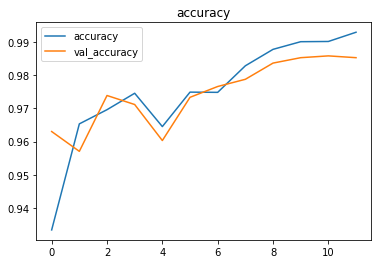

In [19]:
plot(history1.history, history2.history, "accuracy", 'val_accuracy')

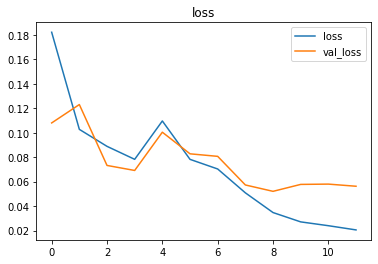

In [20]:
plot(history1.history, history2.history, "loss", 'val_loss')

# Model evaluation

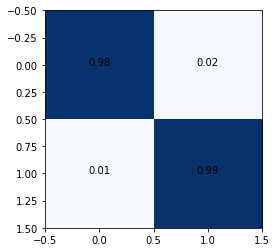

In [21]:
cm = confusion_matrix(ytest, (model.predict(Xtest)>0.5).astype('int'))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


plt.imshow(cm, cmap=plt.cm.Blues)

Balancing the dataset is an important step in achieving high performance.

It is important to note that good results, if not the best can be achieved with an unbalanced dataset too! Try running the same notebook, but skip the resampling section code and see the results!

# Prediction

In [22]:
# pick random test data sample from one batch
x = random.randint(0, len(Xtest) - 1)

output_true = np.array(ytest)[x][0]
print("True: ", class_names[output_true])

output = model.predict(Xtest[x].reshape(1, -1))[0][0]
pred = int(output>0.5)    # finding max
print("Predicted: ", class_names[pred], "(",output, "-->", pred, ")")    # Picking the label from class_names base don the model output

True:  Non-epileptic
Predicted:  Non-epileptic ( 1.701992e-15 --> 0 )


# deepC

In [25]:
model.save('epileptic_seizure.h5')

!deepCC epileptic_seizure.h5

reading [keras model] from 'epileptic_seizure.h5'
Saved 'epileptic_seizure.onnx'
reading onnx model from file  epileptic_seizure.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) dense_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_3's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_3) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  epileptic_seizure_deepC/epileptic_seizure.cpp
INFO (ONNX): model files are ready in dir epileptic_seizure_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 epileptic_seizure_deepC/epileptic_seizure.cpp -o epileptic_seizure_deepC/epileptic_seizure.exe
Model executable  epileptic_sei

In [26]:
# pick random test data sample from one batch
x = random.randint(0, len(Xtest) - 1)

output_true = np.array(ytest)[x][0]
print("True: ", class_names[output_true])

np.savetxt('sample.data', Xtest[i])

# run exe with input
!epileptic_seizure_deepC/epileptic_seizure.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_3.out')

pred = int(nn_out>0.5)    # finding max
print("Predicted: ", class_names[pred], "(",nn_out, "-->", pred, ")")    # Picking the label from class_names base don the model output

True:  Epileptic
reading file sample.data.
writing file dense_3.out.
Predicted:  Epileptic ( 1.0 --> 1 )
